In [1]:
import pandas as pd

train_data = pd.read_pickle('train_dataset.pkl')
test_data = pd.read_pickle('test_dataset.pkl')

In [2]:
print(train_data.shape)
train_data.head(10)

(2000, 3)


,Entry,Label,Sequence
0,A6UQM3,2.7.7.1,MRAFIVGRWQPFHKGHLEIIKKISEEVDEIIIGIGSCQRSHTLTDP...
1,A2SS82,2.7.7.1,MRRGLYVGRFQPFHNGHKAVIDGLAEEVDELIIGIGSADISHDIRH...
2,A0B5N0,2.7.7.1,MRRGFYIGRFQPYHMGHHLVLEQISREVDEIIVGIGTAQISHTVTD...
3,Q9UXN8,2.7.7.1,MRRAFYIGRFQPFHLGHYSLIKDIARDADEVVIGIGSAQKSHEPKN...
4,B0R328,2.7.7.1,MTRGFYIGRFQPFHTGHRRVIEQIATEVDELVVGIGSAGDSHSARN...
5,Q09751,4.4.1.5,MASTTDMSTYKLNHTMIRVKDLDKSLKFYTEVFGMKLIDQWVFEEN...
6,P16635,4.4.1.5,MSLNDLNTLPGVTAQADPATAQFVFNHTMLRVKDIEKSLDFYTRVL...
7,O49818,4.4.1.5,MAASESKESPANNPGLHTTIDEATKGYFMQQTMFRIKDPKVSLDFY...
8,Q04760,4.4.1.5,MAEPQPPSGGLTDEAALSCCSDADPSTKDFLLQQTMLRVKDPKKSL...
9,Q55595,4.4.1.5,MFLLHTMIRVGDLDKSLQFYCDILGMNLLRKKDYPSGEFTLAFVGY...


In [3]:
print(test_data.shape)
test_data.head(4)

(400, 3)


,Entry,Label,Sequence
0,Q9P7T7,2.7.7.1,MDQAKKYANLLDSFRSSTEDILLLERLEVSDKPIYVLDSSFNPPHF...
1,Q9M8R4,4.4.1.5,MANSRTVLILCGDYMEDYEVMVPFQALQAFGITVHTVCPGKKAGDS...
2,P21163,3.5.1.52,MRKLLIFSISAYLMAGIVSCKGVDSATPVTEDRLALNAVNAPADNT...
3,A0A150XSC5,2.7.7.65,MLITSNAKTQLEDTLAKMAEAAELDKTRWSRLNTAYEAISKWLSDD...


In [4]:
from Bio.Seq import Seq
import itertools
import numpy as np

amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

store_kmer_counts_train = np.zeros((train_data.shape[0], 20**2))
store_kmer_counts_test = np.zeros((test_data.shape[0], 20**2))
kmers = ["" for _ in range(20**2)]

col_counter = 0
for kmer_tup in itertools.product(amino_acids, repeat=2):
    kmer = ''.join(kmer_tup)
    kmers[col_counter] = kmer
    store_kmer_counts_train[:, col_counter] = train_data.Sequence.apply(lambda x: Seq(x).count_overlap(kmer))
    store_kmer_counts_test[:, col_counter] = test_data.Sequence.apply(lambda x: Seq(x).count_overlap(kmer))
    col_counter += 1


In [5]:
train_data = pd.concat([train_data, pd.DataFrame(store_kmer_counts_train, columns=kmers)], ignore_index=True)
test_data = pd.concat([test_data, pd.DataFrame(store_kmer_counts_test, columns=kmers)], ignore_index=True)

In [7]:
test_data.fillna(0, inplace=True)
train_data.fillna(0, inplace=True)
test_data.AA.describe()

count    800.000000
mean       1.777500
std        3.377833
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       34.000000
Name: AA, dtype: float64

[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 2
[model=One versus Rest, solver=saga] Number of epochs: 3
Test F1 for model ovr: 0.0017
% non-zero coefficients for model ovr, per class:
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 10

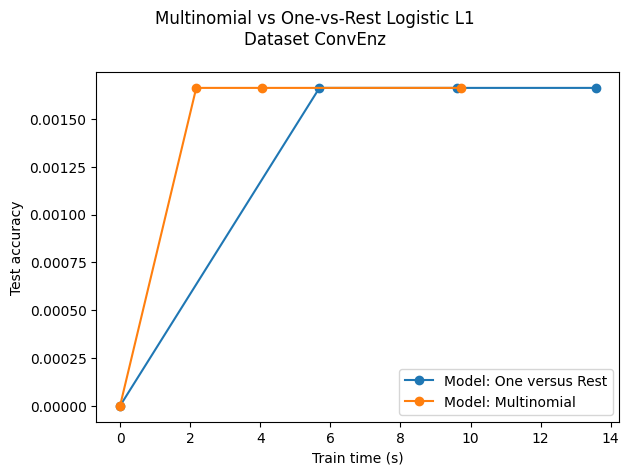

In [8]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import timeit
import warnings

import matplotlib.pyplot as plt
import numpy as np

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsRestClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
t0 = timeit.default_timer()

# We use SAGA solver
solver = "saga"

label_encoder = {
    val: ix for ix, val in enumerate(test_data["Label"])
}

X_train = train_data.iloc[:,3:-1]
y_train = train_data["Label"].apply(lambda x: label_encoder[x])

X_test = test_data.iloc[:,3:-1]
y_test = test_data["Label"].apply(lambda x: label_encoder[x])

train_samples, n_features = X_train.shape
n_classes = np.unique(y_train).shape[0]

models = {
    "ovr": {"name": "One versus Rest", "iters": [1, 2, 3]},
    "multinomial": {"name": "Multinomial", "iters": [1, 2, 5]},
}
for model in models:
    # Add initial chance-level values for plotting purpose
    f1s = [0]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params["iters"]:
        print(
            "[model=%s, solver=%s] Number of epochs: %s"
            % (model_params["name"], solver, this_max_iter)
        )
        clf = LogisticRegression(
            solver=solver,
            penalty="l1",
            max_iter=this_max_iter,
            random_state=42,
        )
        if model == "ovr":
            clf = OneVsRestClassifier(clf)
        t1 = timeit.default_timer()
        clf.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        if model == "ovr":
            coef = np.concatenate([est.coef_ for est in clf.estimators_])
        else:
            coef = clf.coef_
        density = np.mean(coef != 0, axis=1) * 100
        f1s.append(f1)
        densities.append(density)
        times.append(train_time)
    models[model]["times"] = times
    models[model]["densities"] = densities
    models[model]["f1s"] = f1s
    print("Test F1 for model %s: %.4f" % (model, f1s[-1]))
    print(
        "%% non-zero coefficients for model %s, per class:\n %s"
        % (model, densities[-1])
    )
    print(
        "Run time (%i epochs) for model %s:%.2f"
        % (model_params["iters"][-1], model, times[-1])
    )

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]["name"]
    times = models[model]["times"]
    f1s = models[model]["f1s"]
    ax.plot(times, f1s, marker="o", label="Model: %s" % name)
    ax.set_xlabel("Train time (s)")
    ax.set_ylabel("Test accuracy")
ax.legend()
fig.suptitle("Multinomial vs One-vs-Rest Logistic L1\nDataset %s" % "ConvEnz")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [103]:
count_enc_train_data = pd.read_pickle('train_dataset.pkl')
count_enc_test_data = pd.read_pickle('test_dataset.pkl')

In [104]:
for aa in amino_acids:
    count_enc_train_data[aa] = count_enc_train_data.Sequence.apply(lambda x: x.count(aa)/len(x))
    count_enc_test_data[aa] = count_enc_test_data.Sequence.apply(lambda x: x.count(aa)/len(x))

In [107]:
count_enc_train_data["length"] = count_enc_train_data.Sequence.apply(lambda x: len(x))
count_enc_test_data["length"] = count_enc_test_data.Sequence.apply(lambda x: len(x))
print(count_enc_test_data.head())
print(count_enc_train_data.head())

        Entry     Label                                           Sequence  \
0      Q9P7T7   2.7.7.1  MDQAKKYANLLDSFRSSTEDILLLERLEVSDKPIYVLDSSFNPPHF...   
1      Q9M8R4   4.4.1.5  MANSRTVLILCGDYMEDYEVMVPFQALQAFGITVHTVCPGKKAGDS...   
2      P21163  3.5.1.52  MRKLLIFSISAYLMAGIVSCKGVDSATPVTEDRLALNAVNAPADNT...   
3  A0A150XSC5  2.7.7.65  MLITSNAKTQLEDTLAKMAEAAELDKTRWSRLNTAYEAISKWLSDD...   
4      A8E7C5  3.1.3.25  MELFQAKDHYILQSGDNALWCSRKDGSMAVRPATDLLLAWNPVCLG...   

          A         C         D         E         F         G         H  ...  \
0  0.052209  0.028112  0.052209  0.052209  0.040161  0.036145  0.020080  ...   
1  0.100515  0.036082  0.056701  0.054124  0.046392  0.092784  0.028351  ...   
2  0.081921  0.019774  0.050847  0.039548  0.042373  0.076271  0.011299  ...   
3  0.058511  0.007979  0.050532  0.090426  0.042553  0.047872  0.021277  ...   
4  0.056250  0.016964  0.062500  0.069643  0.032143  0.062500  0.026786  ...   

          N         P         Q         R         

[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 2
[model=One versus Rest, solver=saga] Number of epochs: 3
[model=One versus Rest, solver=saga] Number of epochs: 10
[model=One versus Rest, solver=saga] Number of epochs: 100
[model=One versus Rest, solver=saga] Number of epochs: 1000
Test F1 for model ovr: 0.0000
% non-zero coefficients for model ovr, per class:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

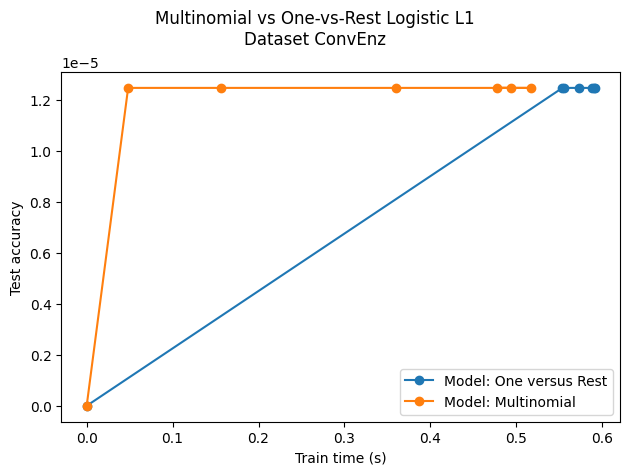

In [105]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import timeit
import warnings

import matplotlib.pyplot as plt
import numpy as np

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
t0 = timeit.default_timer()

# We use SAGA solver
solver = "saga"

label_encoder = {
    val: ix for ix, val in enumerate(test_data["Label"])
}

X_train = count_enc_train_data.iloc[:,3:-1]
y_train = count_enc_train_data["Label"].apply(lambda x: label_encoder[x])

X_test = count_enc_test_data.iloc[:,3:-1]
y_test = count_enc_test_data["Label"].apply(lambda x: label_encoder[x])

train_samples, n_features = X_train.shape
n_classes = np.unique(y_train).shape[0]

models = {
    "ovr": {"name": "One versus Rest", "iters": [1, 2, 3, 10, 100, 1000]},
    "multinomial": {"name": "Multinomial", "iters": [1, 2, 5, 10, 100,1000]},
}

for model in models:
    # Add initial chance-level values for plotting purpose
    f1s = [0]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params["iters"]:
        print(
            "[model=%s, solver=%s] Number of epochs: %s"
            % (model_params["name"], solver, this_max_iter)
        )
        clf = LogisticRegression(
            solver=solver,
            penalty="l1",
            max_iter=this_max_iter,
            random_state=42,
        )
        if model == "ovr":
            clf = OneVsRestClassifier(clf)
        t1 = timeit.default_timer()
        clf.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred, average="macro")
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        if model == "ovr":
            coef = np.concatenate([est.coef_ for est in clf.estimators_])
        else:
            coef = clf.coef_
        density = np.mean(coef != 0, axis=1) * 100
        f1s.append(f1)
        densities.append(density)
        times.append(train_time)
    models[model]["times"] = times
    models[model]["densities"] = densities
    models[model]["f1s"] = f1s
    print("Test F1 for model %s: %.4f" % (model, f1s[-1]))
    print(
        "%% non-zero coefficients for model %s, per class:\n %s"
        % (model, densities[-1])
    )
    print(
        "Run time (%i epochs) for model %s:%.2f"
        % (model_params["iters"][-1], model, times[-1])
    )

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]["name"]
    times = models[model]["times"]
    f1s = models[model]["f1s"]
    ax.plot(times, f1s, marker="o", label="Model: %s" % name)
    ax.set_xlabel("Train time (s)")
    ax.set_ylabel("Test accuracy")
ax.legend()
fig.suptitle("Multinomial vs One-vs-Rest Logistic L1\nDataset %s" % "ConvEnz")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [70]:
from Bio import Align
import pickle

## WARNING this takes about an hour to run

aligner = Align.PairwiseAligner(scoring="blastp")

results = {
    "true": count_enc_test_data.Label,
    "best_1": ["" for _ in range(len(count_enc_test_data.Label))],
    "best_10_NN": ["" for _ in range(len(count_enc_test_data.Label))]
}

for test_row in range(count_enc_test_data.shape[0]):
    if test_row % 10 == 0:
        print(test_row)
    test_seq = count_enc_test_data.Sequence.iloc[test_row]
    true_label = count_enc_test_data.Label.iloc[test_row]
    
    scores_and_votes = []
    test_seq = test_seq.replace("U","X") # deal with selenocysteines
    
    for train_row in range(count_enc_train_data.shape[0]):
        train_seq = count_enc_train_data.Sequence.iloc[train_row]
        train_label = count_enc_train_data.Label.iloc[train_row]
        
        train_seq = train_seq.replace("U","X") # selenocysteines
        alignments = aligner.align(test_seq, train_seq)
        scores_and_votes.append((alignments[0].score, 
                                 train_label))

    scores_and_votes.sort(key=lambda tup: tup[0], reverse=True)
    best_votes = [v[1] for v in scores_and_votes[:10]] # top 10 votes

    #print(true_label)
    #print(best_votes[0])
    results["best_1"][test_row] = best_votes[0]
    #print(max(set(best_votes), key=best_votes.count))
    results["best_10_NN"][test_row] = max(set(best_votes), key=best_votes.count)
    #print("-------")

#with open("knn_results.pkl", "wb") as file:
#    pickle.dump(results, file)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


In [64]:
aligner = Align.PairwiseAligner(scoring="blastp",
                                target_left_open_gap_score=-4,
                                target_right_open_gap_score=-4,
                                query_left_open_gap_score=-4,
                                query_right_open_gap_score=-4)
print(aligner)

Pairwise sequence aligner with parameters
  substitution_matrix: <Array object at 0x15e90d140>
  target_internal_open_gap_score: -12.000000
  target_internal_extend_gap_score: -1.000000
  target_left_open_gap_score: -4.000000
  target_left_extend_gap_score: -1.000000
  target_right_open_gap_score: -4.000000
  target_right_extend_gap_score: -1.000000
  query_internal_open_gap_score: -12.000000
  query_internal_extend_gap_score: -1.000000
  query_left_open_gap_score: -4.000000
  query_left_extend_gap_score: -1.000000
  query_right_open_gap_score: -4.000000
  query_right_extend_gap_score: -1.000000
  mode: global



In [72]:
len(results)

3

In [76]:
sum(results['true'] == results['best_1'])/400

0.115

In [77]:
sum(results['true'] == results['best_10_NN'])/400

0.105

In [83]:
for avg_type in ["macro", "micro", "weighted"]:
    print(f1_score(results['best_1'], results['true'], average=avg_type))

0.08833333333333333
0.115
0.14166666666666666


In [84]:
# macro average is used in https://github.com/TattaBio/DGEB/blob/main/dgeb/evaluators.py
for avg_type in ["macro", "micro", "weighted"]:
    print(f1_score(results['best_10_NN'], results['true'], average=avg_type))

0.07858333333333332
0.10499999999999998
0.13141666666666665


In [86]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

results_true_enc = label_encoder.fit_transform(results['true'])
results_best10_NN_enc = label_encoder.transform(results['best_10_NN'])

for avg_type in ["macro", "micro", "weighted"]:
    print(f1_score(results['best_10_NN'], results['true'], average=avg_type))

0.07858333333333332
0.10499999999999998
0.13141666666666665


In [90]:
for i in range(len(results['best_1'])):
    print(results['true'][i])
    print(count_enc_test_data.Entry.iloc[i])
    print(results['best_1'][i])
    print("--")

2.7.7.1
Q9P7T7
4.2.1.10
--
4.4.1.5
Q9M8R4
6.2.1.5
--
3.5.1.52
P21163
3.2.1.96
--
2.7.7.65
A0A150XSC5
2.7.7.85
--
3.1.3.25
A8E7C5
3.1.3.64
--
4.2.99.18
P79891
3.1.26.3
--
5.3.1.9
A6UCB5
2.5.1.3
--
2.1.1.355
Q13029
2.7.10.2
--
2.7.7.101
Q74MB1
2.7.7.65
--
2.7.1.39
A8MI61
2.7.1.71
--
2.4.1.25
O32462
3.2.1.1
--
2.5.1.60
P46960
3.1.21.2
--
3.5.1.23
O06769
5.4.2.12
--
2.7.4.3
A9BFZ7
2.7.4.25
--
7.1.2.2
B5YBQ0
7.4.2.8
--
1.8.1.8
Q0JIL1
1.4.1.1
--
3.2.1.18
Q64627
1.1.1.1
--
2.3.1.20
P9WKB3
3.5.2.3
--
3.6.1.31
A1A1J2
3.6.1.31
--
3.1.3.18
P0DKC3
3.1.3.27
--
1.5.1.3
P00383
7.2.4.3
--
2.3.1.51
Q9LHN4
4.2.99.18
--
3.1.1.96
O29630
1.1.1.27
--
2.4.1.122
Q4KXC9
3.2.1.17
--
1.17.4.1
Q9SJ20
6.5.1.3
--
2.7.8.26
Q97BG1
2.7.8.26
--
4.1.1.31
O28786
3.1.11.6
--
1.17.1.4
O32147
2.7.1.121
--
7.2.4.2
P13187
4.1.3.39
--
5.6.2.1
O60126
2.3.3.9
--
3.6.1.41
P54456
4.2.99.18
--
3.1.26.11
Q49744
1.6.5.2
--
1.14.11.27
A8E534
2.7.7.15
--
2.7.7.4
B3PII1
2.6.1.57
--
3.1.26.4
B4SAK8
2.4.2.8
--
1.1.1.169
F4KIN4
1.2.4.4
--


In [109]:
print(count_enc_test_data.Label[399])
print(count_enc_test_data.Entry[399])
count_enc_test_data.Sequence[399]

3.6.1.9
A5FQJ4


'MPDNPTGTLPEIILASASPRRRQILSEMGFIFSVCPSQAELYPDGSVAPAEFAVLNAQIKARDIASKYSNGLIIAADTIVVDDFGILGKPSSKKVALNYLSRLGGKPHTVISSVCLLNTENGQIRSATCQSTLTMRPYTQAEAQRYVDSGLPMDKAGAYGIQDKEFNPVENIQGCYLNVVGLPACTLVRLINEMGFNPKLARNWKPEGDCTLCRIYRTEISRLR'

In [110]:
count_enc_train_data[count_enc_train_data.Label == "3.6.1.9"]

,Entry,Label,Sequence,A,C,D,E,F,G,H,...,N,P,Q,R,S,T,V,W,Y,length
1995,Q0UFP3,3.6.1.9,MSPTPAHLNFITGNKNKLAEVQAILAGVIELRNENIDLVEIQGSVE...,0.106383,0.026596,0.058511,0.079787,0.042553,0.079787,0.021277,...,0.037234,0.042553,0.042553,0.031915,0.042553,0.047872,0.058511,0.015957,0.021277,188
1996,F6HS55,3.6.1.9,MAAAGASASGLILSRPVTFVTGNAKKLEEVRYILGQSIPFNSLKLD...,0.101942,0.014563,0.043689,0.067961,0.053398,0.082524,0.014563,...,0.038835,0.082524,0.033981,0.024272,0.053398,0.033981,0.048544,0.009709,0.038835,206
1997,Q752Z9,3.6.1.9,MPNLVFVTGNANKLREVRQLLGGAALPYPLVNEPLDLDEVQAASLD...,0.161616,0.025253,0.065657,0.040404,0.050505,0.070707,0.020202,...,0.025253,0.095960,0.020202,0.050505,0.035354,0.065657,0.055556,0.010101,0.025253,198
1998,Q4WTN9,3.6.1.9,MIPTVKLNFITSNKNKLAEVKAILGNVVEIDSQAIEVPEIQGSIEE...,0.090909,0.010695,0.042781,0.106952,0.048128,0.090909,0.021390,...,0.042781,0.053476,0.021390,0.053476,0.037433,0.042781,0.048128,0.010695,0.016043,187
1999,Q54LQ6,3.6.1.9,MSISKKIVFVTGNAKKLEEALQILGTSFPIESKKVDLPELQGDPID...,0.056701,0.025773,0.061856,0.087629,0.056701,0.077320,0.005155,...,0.030928,0.067010,0.025773,0.025773,0.061856,0.036082,0.056701,0.015464,0.030928,194


In [98]:
count_enc_train_data.shape

(2000, 24)

In [111]:
count_enc_train_data[count_enc_train_data.Label == "2.4.2.17"]

,Entry,Label,Sequence,A,C,D,E,F,G,H,...,N,P,Q,R,S,T,V,W,Y,length
1195,Q6BRU4,2.4.2.17,MDLVNHLPDRLLFAVPKKGRLYEKCCSLLKGVDIQFRRSNRLDIAI...,0.078947,0.023026,0.065789,0.072368,0.036184,0.059211,0.009868,...,0.032895,0.036184,0.032895,0.039474,0.082237,0.042763,0.075658,0.003289,0.016447,304
1196,Q2G469,2.4.2.17,MSTAAPLVFALPKGRILDEALPLLEKAGIVPEAEFFDKSSRALSFA...,0.161435,0.004484,0.062780,0.058296,0.040359,0.058296,0.022422,...,0.026906,0.044843,0.004484,0.076233,0.067265,0.040359,0.103139,0.000000,0.013453,223
1197,A0KWB6,2.4.2.17,MTESNRLRIAIQKSGRLSTDSQQLLKSCGIKFSINEQRLIAHADNM...,0.080268,0.016722,0.063545,0.070234,0.020067,0.060201,0.010033,...,0.036789,0.040134,0.046823,0.066890,0.076923,0.056856,0.063545,0.003344,0.020067,299
1198,Q75AK8,2.4.2.17,MDLVRQLNDRLLFAVPKKGRLYEKSVALLNGADILFHRSHRLDIAL...,0.107744,0.020202,0.067340,0.050505,0.026936,0.074074,0.016835,...,0.023569,0.043771,0.030303,0.074074,0.063973,0.057239,0.087542,0.003367,0.026936,297
1199,Q9RH04,2.4.2.17,MTKPLVFAIPKGRILKEALPMLEAAGIIPEPAFLDKESRLLRFKTN...,0.121622,0.009009,0.054054,0.081081,0.040541,0.063063,0.027027,...,0.027027,0.063063,0.009009,0.085586,0.036036,0.027027,0.085586,0.004505,0.013514,222


Text(0.5, 1.0, 'PCA of IRIS dataset')

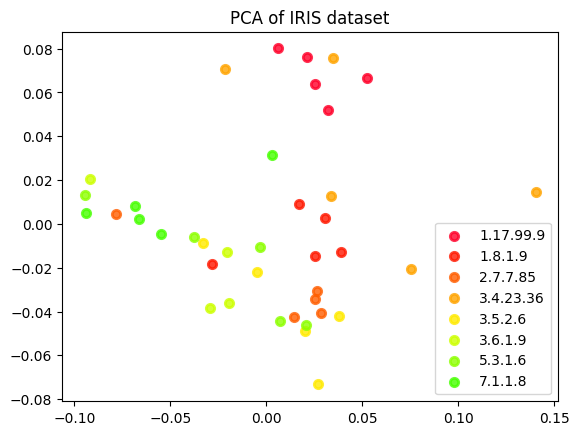

In [120]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_train = count_enc_train_data.iloc[1960:-1,3:-1]
target_names = count_enc_train_data["Label"][1960:-1]

X_test = count_enc_test_data.iloc[:,3:-1]
y_test = count_enc_test_data["Label"].apply(lambda x: label_encoder[x])

pca = PCA(n_components=2)
X_r = pca.fit(X_train).transform(X_train)

plt.figure()

n_colors = 20
cm = plt.get_cmap('gist_rainbow')
colors=[cm(1.*i/n_colors) for i in range(n_colors)]
lw=2

for color, i in zip(colors, np.unique(target_names)):
    plt.scatter(
        X_r[target_names == i, 0], X_r[target_names == i, 1], 
        color=color, alpha=0.8, lw=lw, label=i
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

In [114]:
X_r

array([[-0.07502616, -0.04641833],
       [-0.00756134, -0.02342832],
       [ 0.00112274, -0.02880239],
       ...,
       [ 0.07647396, -0.00529577],
       [-0.00649794, -0.03262114],
       [-0.05115502, -0.02627199]])